# BioData West Open Targets Datathon
**Matthew R. Nelson**

**March 12, 2018**

## Introduction
There has been exponential growth in the genomic data being produced to yield new insights into biology, and particularly with the intent to understand the role of genes and proteins and pathways in disease.  Despite this, selecting protein targets for drug discovery still seems more of an art, guided by intuition and influenced by cognitive biases, than a reproducible science.  Open Targets was established to bring the data and science together in a pre-competitive environment to help foster better early discovery decision making.  In this dual session, we will introduce and engage the participants to the science of target selection.  In this datathon, you will be introduced to the evidence types Open Targets is currently using to established relationships between genes and disease to aid in selecting and validating prospective drug targets.

You will be introduced to several genomic and gene-disease data sources.  You are tasked with exploring methods for using these data for predicting drug development success.  Insights and feedback from among the participants will be collated and shared, and may be used in future development of the Open Targets platform.  

Prior to the datathon, you are encouraged to download the data files, view the example analysis notebooks available in R and Python, and review the data documentation.  A brief summary will be provided during the introductory session and researchers from Open Targets and GSK will be on hand to answer any questions you may have.  

At the datathon, you will be divided into small groups where you can work individually or jointly to explore these data, their relationships to development outcomes, and methods of modeling them to predict outcomes.  At the end of the datathon, groups will be invited to share their experiences and discuss potential next steps.  You are welcome to use whatever analysis tools you prefer for this analysis exercise.




## Data Import

The three primary datathon files are summarized below.  You can find a more complete description of each data file and the variables within them at the datathon Wiki site.

**Note about neoplasm versus non-neoplasm indications:** Because the genomic evidence that may be important for neoplasms may be very different than for non-neoplasms, we restrict this summary of the data to non-neoplasm data only.

In [1]:
## Load packages to use
library(ggplot2) # Plotting functions
library(tidyr) # Use gather() for reformatting to long-skinny
library(dplyr) # Using chaining (%>%) and several dplyr verbs


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



### Pharmaprojects data
The first data file, Pprojects_drugs_TTlabel.csv, is derived from Informa Pharmaprojects, a commercial database tracking the development of over 68,000 drugs over the past several decades.  Researchers at GSK have carefully processed and curated this database to create a summary of all target-indication pairs (T-I) that have entered clinical development, tracking the furthest stage of development achieved.  A T-I is considered successful if any drug annotated to act through the selected target was approved for the accompanying indication.  Further details are available on the See [the datathon Wiki site](https://github.com/opentargets/biodatawest_hackathon/wiki/Open-Targets-hackathon-datasets-description) for details.  The objective of this datathon is to identify the genomic factors that predict successful T-Is (for example, see the related paper by Nelson et al. 2015).  Informa has permitted us to make these data freely available to the datathon participants during the course of this datathon.  They must be permanently deleted after the datathon work is completed, as agreed in the survey.  We have identified 80%/20% of T-Is as a training set and test set.  We encourage any participants interested in exploring predictive models to use them as such.

In [2]:
pp.data = read.csv("Pprojects_drugs_TTlabel.csv",
                  na.strings = c("NA", ""), header = TRUE) %>%
  filter(DiseaseType %in% "Non-Neoplasm") %>% 
  rename(key = target_indication)

In [3]:
summary(pp.data)

                           key              ensembl_gene_id       disease_id  
 ENSG00000000971-EFO_0000253 :   1   ENSG00000113580:  97   EFO_0000685: 171  
 ENSG00000001626-EFO_0000555 :   1   ENSG00000073756:  85   EFO_0000676: 158  
 ENSG00000001626-HP_0002014  :   1   ENSG00000095303:  79   EFO_0000198: 138  
 ENSG00000001626-Orphanet_586:   1   ENSG00000065989:  63   EFO_0003843: 128  
 ENSG00000001630-EFO_0003914 :   1   ENSG00000184588:  61   EFO_0000270: 126  
 ENSG00000003436-EFO_0001420 :   1   ENSG00000105650:  59   EFO_0000249: 113  
 (Other)                     :7874   (Other)        :7436   (Other)    :7046  
   entrez_id            MeSH_ID           DiseaseType  
 Min.   :        2   D001172: 171   Neoplasm    :   0  
 1st Qu.:     1815   D011565: 158   Non-Neoplasm:7880  
 Median :     3596   D009190: 138                      
 Mean   :    35198   D001249: 126                      
 3rd Qu.:     5743   D000544: 113                      
 Max.   :100133941   D003924: 11

### Open Targets Evidence Scores

The second dataset includes the evidence scores that are available through the [Open Targets Portal](http://www.targetvalidation.org/).  See [the datathon Wiki pages](https://github.com/opentargets/biodatawest_hackathon/wiki/Open-Targets-hackathon-datasets-description) for details.

The data file provided includes target evidence scores for all target-indication combinations available in the Open Targets database (over 2.3 million).  As the focus of this exercise is to predict clinical success of target-indication pairs, I have imported the large data file and saved the overlap with Pharmaprojects as a separate, much smaller data set.

In [4]:
## Create a small dataset matched to pp.data
#ot.data.all = read.csv("gene_disease_associations_datatypes_with_expression.csv",
#                       na.strings = c("NA", ""), header = TRUE)
#write.table(subset(ot.data.all, key %in% pp.data$target_indication),
#            file = "PP_gene_disease_associations_datatypes_with_expression.csv", 
#            sep = ",", na = "NA", 
#            row.names = FALSE)

Now we can simply import the smaller dataset to make re-running this notebook much simpler.

In [5]:
ot.data <- read.csv("PP_gene_disease_associations_datatypes_with_expression.csv", 
                    na.strings = c("NA", ""), header = TRUE)
dim(ot.data)
summary(ot.data)

[1] 5090   19

                             key         entrez_id        
 ENSG00000000971-EFO_0000253   :   1   Min.   :        2  
 ENSG00000001626-EFO_0000555   :   1   1st Qu.:     1815  
 ENSG00000001626-HP_0002014    :   1   Median :     3588  
 ENSG00000001626-Orphanet_586  :   1   Mean   :    29582  
 ENSG00000003436-Orphanet_903  :   1   3rd Qu.:     5743  
 ENSG00000003436-Orphanet_98878:   1   Max.   :100133941  
 (Other)                       :5084                      
        ensembl_gene_id     symbol           disease_id  
 ENSG00000113580:  72   NR3C1  :  72   EFO_0000685: 148  
 ENSG00000073756:  71   PTGS2  :  71   EFO_0000676: 135  
 ENSG00000095303:  56   PTGS1  :  56   EFO_0000270: 116  
 ENSG00000232810:  51   TNF    :  51   EFO_0003843: 115  
 ENSG00000149295:  46   DRD2   :  46   EFO_0000198: 102  
 ENSG00000113448:  36   PDE4B  :  36   EFO_0000249:  98  
 (Other)        :4758   (Other):4758   (Other)    :4376  
                  disease_label 
 rheumatoid arthritis    : 148 

### Open Targets data broken down to specific data sources

The third data file has the same structure as the Open Targets data types score file, but breaks the data types down into the data sources that they were derived from.  For example, the genetic_association score is derived from a combination of the uniprot, gwas_catalog, phewas_catalog, eva, uniprot_literature, genomics_england and gene2phenotype genetic scores.  You may use any predictive models developed over the course of this datathon to identify the T-I that are expected to be the most effective drug discovery opportunities. See [the datathon Wiki page](https://github.com/opentargets/biodatawest_hackathon/wiki/Open-Targets-hackathon-datasets-description) for details.

As above, the subset of this data set that overlaps with Pharmaprojects has been saved to make re-running this notebook simpler.  (Reading the entire data file takes 30+ seconds on my laptop... I'm not that patient.)

In [6]:
## Create a small dataset matched to pp.data
##otsource.data.all = read.csv("gene_disease_associations_datasources_with_expression.csv", 
##                             na.strings = c("NA", ""), header = TRUE)
##write.table(subset(otsource.data.all, key %in% pp.data$target_indication),
##            file = "PP_gene_disease_associations_datasources_with_expression.csv", 
##            sep = ",", na = "NA", 
##            row.names = FALSE)

In [7]:
otsource.data <- read.csv("PP_gene_disease_associations_datasources_with_expression.csv", 
                    na.strings = c("NA", ""), header = TRUE)
dim(otsource.data)
summary(otsource.data)

[1] 5090   29

                             key         entrez_id        
 ENSG00000000971-EFO_0000253   :   1   Min.   :        2  
 ENSG00000001626-EFO_0000555   :   1   1st Qu.:     1815  
 ENSG00000001626-HP_0002014    :   1   Median :     3588  
 ENSG00000001626-Orphanet_586  :   1   Mean   :    29582  
 ENSG00000003436-Orphanet_903  :   1   3rd Qu.:     5743  
 ENSG00000003436-Orphanet_98878:   1   Max.   :100133941  
 (Other)                       :5084                      
        ensembl_gene_id     symbol           disease_id  
 ENSG00000113580:  72   NR3C1  :  72   EFO_0000685: 148  
 ENSG00000073756:  71   PTGS2  :  71   EFO_0000676: 135  
 ENSG00000095303:  56   PTGS1  :  56   EFO_0000270: 116  
 ENSG00000232810:  51   TNF    :  51   EFO_0003843: 115  
 ENSG00000149295:  46   DRD2   :  46   EFO_0000198: 102  
 ENSG00000113448:  36   PDE4B  :  36   EFO_0000249:  98  
 (Other)        :4758   (Other):4758   (Other)    :4376  
                  disease_label 
 rheumatoid arthritis    : 148 

### Additional Gene Characteristics of Interest

In addition to the current Open Targets evidence scores, we include a number of other genomic characteristics that may be insightful in differentiating between effective and ineffective mechanisms.  See [the datathon Wiki pages](https://github.com/opentargets/biodatawest_hackathon/wiki/Open-Targets-hackathon-datasets-description) for details.

In [8]:
##gene.data.all <- read.csv("gene_info_qtq.csv", 
##                          na.strings = c("NA", ""), header = TRUE)
##write.table(subset(gene.data.all, entrez_id %in% pp.data$entrez_id),
##            file = "PP_gene_info_qtq.csv", sep = ",", na = "NA", 
##            row.names = FALSE)

In [9]:
gene.data <- read.csv("PP_gene_info_qtq.csv", 
                    na.strings = c("NA", ""), header = TRUE) %>%
  select(-X, -hgnc_id, -ensembl_gene_id, -uniprot_id)
dim(gene.data)
length(unique(gene.data$entrez_id))
summary(gene.data)


[1] 40518    16

[1] 1108

     symbol        entrez_id                              locus_type   
 JAK2   :  248   Min.   :        2   endogenous retrovirus     :    7  
 TGFB1  :  231   1st Qu.:     1815   gene with protein product :40486  
 CTNNB1 :  218   Median :     3757   immunoglobulin gene       :   17  
 AKT1   :  179   Mean   :    96704   RNA, micro                :    5  
 SIRT1  :  177   3rd Qu.:     6387   RNA, misc                 :    1  
 (Other):39464   Max.   :100133941   T-cell receptor gene      :    1  
 NA's   :    1                       T-cell receptor pseudogene:    1  
              locus_group           go_id      
 non-coding RNA     :    6   GO:0005886:  842  
 other              :   25   GO:0005515:  775  
 protein-coding gene:40486   GO:0005829:  456  
 pseudogene         :    1   GO:0005576:  390  
                             GO:0005887:  358  
                             (Other)   :37686  
                             NA's      :   11  
                                  go_lab

Most of the descriptors in this data set have a single value for each gene:

In [10]:
apply(gene.data, 2, function(x) length(unique(paste(gene.data$symbol, x))))

symbol               entrez_id              locus_type 
                   1108                    1108                    1108 
            locus_group                   go_id                go_label 
                   1108                   37167                   37167 
          evidence_type          reported_count           protein_class 
                   6620                    3886                    1124 
           target_class           topology_type         target_location 
                   1108                    1108                    1108 
               ExAC_LoF  pc_mouse_gene_identity GTEX_median_all_tissues 
                   1108                    1108                    1108 
            description 
                   1108

In this analysis, I'm not doing anything sophisticated with the various GO terms.  To simplify this, I create an analysis version by reducing this data set to the first occurance of each each gene.

In [11]:
ugene.data <- gene.data %>%
    subset(!duplicated(symbol))

### Merge all data sets into single data frame for analysis

In [12]:
all.data <- pp.data %>%
    filter(Clinical.Label_PP %in% c("Clinical Failure", 
                                    "Succeeded")) %>%
    inner_join(ot.data) %>%
    left_join(otsource.data) %>%
    left_join(ugene.data) %>%
    mutate(clinical.outcome = 
           droplevels(recode_factor(Clinical.Label_PP, 
                                    `Clinical Failure` = "Failure", 
                                    `Succeeded` = "Success")))
dim(all.data)
summary(all.data)

Joining, by = c("key", "ensembl_gene_id", "disease_id", "entrez_id")
Warning message:
"Column `key` joining factors with different levels, coercing to character vector"Warning message:
"Column `ensembl_gene_id` joining factors with different levels, coercing to character vector"Warning message:
"Column `disease_id` joining factors with different levels, coercing to character vector"Joining, by = c("key", "ensembl_gene_id", "disease_id", "entrez_id", "symbol", "disease_label", "therapeutic_area", "is_direct", "tissue_label", "source", "max_fold_change", "expression_score")
Warning message:
"Column `key` joining character vector and factor, coercing into character vector"Warning message:
"Column `ensembl_gene_id` joining character vector and factor, coercing into character vector"Warning message:
"Column `disease_id` joining character vector and factor, coercing into character vector"Joining, by = c("entrez_id", "symbol")
Warning message:
"Column `symbol` joining factors with different l

[1] 4047   59

     key            ensembl_gene_id     disease_id          entrez_id        
 Length:4047        Length:4047        Length:4047        Min.   :        2  
 Class :character   Class :character   Class :character   1st Qu.:     1813  
 Mode  :character   Mode  :character   Mode  :character   Median :     3559  
                                                          Mean   :    33468  
                                                          3rd Qu.:     5742  
                                                          Max.   :100133941  
                                                                             
    MeSH_ID           DiseaseType              Clinical.Label_PP
 D001172: 128   Neoplasm    :   0   Clinical Failure    :2757   
 D011565: 114   Non-Neoplasm:4047   In Progress Clinical:   0   
 D001249: 104                       Succeeded           :1290   
 D000544:  73                                                   
 D003924:  73                                      

## Data Exploration
In this section, we perform some basic exploratory data visualizations and summaries to understand the score and evidence distributions and their relationships with clinical success.

### Quantitative Open Targets scores

Put data into a long format to permit trellised ggplots

In [13]:
id.vars = c('key', 'symbol', 'disease_label')
outcome.vars = c('Clinical.Label_PP', 'Furthest.Phase', 
                 'Therapeutic.Direction', 'clinical.outcome')
ot.scores = c('genetic_association',
              'known_drug', 'rna_expression',
           'affected_pathway', 'animal_model', 'literature')
otsrc.scores = c('expression_atlas', 'uniprot', 'gwas_catalog', 
                 'phewas_catalog',
                 'eva', 'uniprot_literature', 'genomics_england', 
                 'gene2phenotype',
                 'reactome', 'slapenrich', 'phenodigm', 'europepmc', 
                 'expression_score')
gene.qvars = c('pc_mouse_gene_identity', 'GTEX_median_all_tissues')
gene.cvars = c('protein_class', 'target_class', 'topology_type', 
               'target_location', 'ExAC_LoF')

In [14]:
all.long = gather(all.data[, c(id.vars, outcome.vars, ot.scores, 
                               otsrc.scores, gene.qvars)], 
                  datasource, score, 
                  genetic_association:GTEX_median_all_tissues, 
                  factor_key = TRUE)
ot.long = gather(all.data[, c(id.vars, outcome.vars, ot.scores, 
                              otsrc.scores)], 
                 datasource, score, 
                 genetic_association:expression_score, 
                 factor_key = TRUE)

In [15]:
dim(ot.long)
summary(ot.long)

[1] 76893     9

     key               symbol                            disease_label  
 Length:76893       Length:76893       rheumatoid arthritis     : 2432  
 Class :character   Class :character   psoriasis                : 2166  
 Mode  :character   Mode  :character   asthma                   : 1976  
                                       pain                     : 1938  
                                       Alzheimers disease       : 1387  
                                       type II diabetes mellitus: 1387  
                                       (Other)                  :65607  
            Clinical.Label_PP            Furthest.Phase 
 Clinical Failure    :52383   Clinical Phase I  :14763  
 In Progress Clinical:    0   Clinical Phase II :28348  
 Succeeded           :24510   Clinical Phase III: 8626  
                              Succeeded         :24510  
                              Withdrawn         :  646  
                                                        
                 

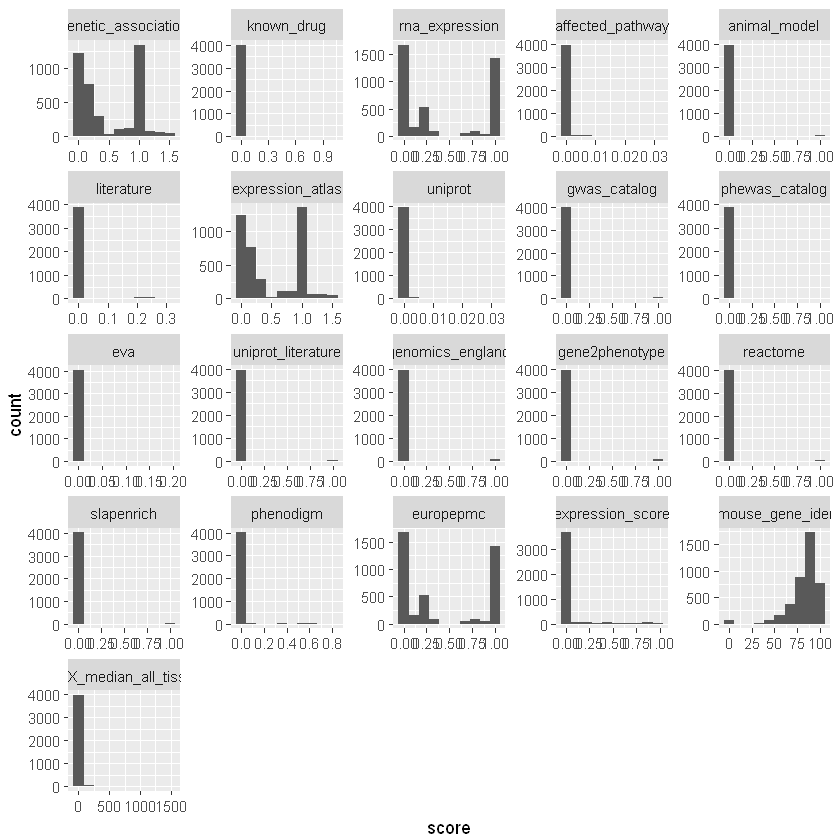

In [16]:
g = ggplot(all.long, aes(score)) +
  geom_histogram(bins = 10) + 
  facet_wrap(~datasource, scales = "free")
print(g)

`geom_smooth()` using method = 'gam'
Warning message:
"Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k."Warning message:
"Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k."Warning message:
"Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k."Warning message:
"Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k."Warning message:
"Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k."

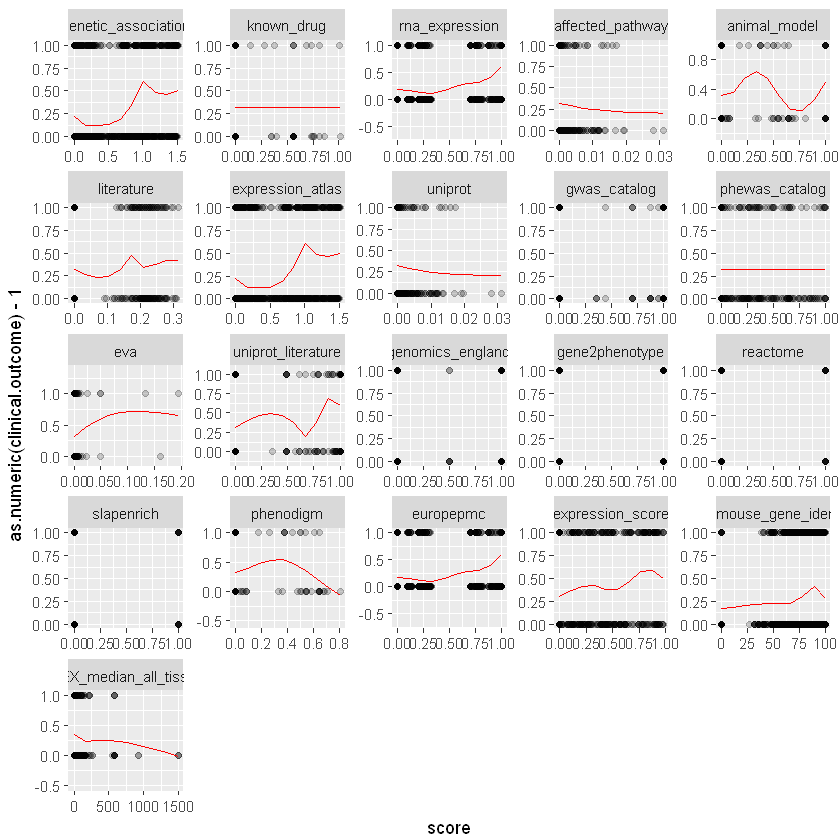

In [17]:
g = ggplot(all.long, aes(score, as.numeric(clinical.outcome) - 1)) +
    geom_point(alpha = 0.2) +  
    stat_smooth(geom = "line", n = 10, color = "red") + 
    facet_wrap(~datasource, scales = "free")
print(g)

### Converting scores into binary measures of positive and negative evidence

Looking at the relationship between the various Open Targets scores and T-I success, it appears that score values below 0.25 are generally associated with lower success rates, though this varies for many score types.  Let's set a threshold value of 0.1 and call everything that exceeds that as having positive evidence.

In [18]:
pos.score.vars = paste(c(ot.scores, otsrc.scores), ".pos", sep = "")
names(pos.score.vars) = c(ot.scores, otsrc.scores)
for(i in names(pos.score.vars)) {
    all.data[, pos.score.vars[i]] = cut(all.data[, i], c(0, 0.1, 100), 
                                        labels = c("Negative", "Positive"),
                                        include.lowest = TRUE)
}
do.call("rbind", apply(all.data[, pos.score.vars], 2, table))

,Negative,Positive
genetic_association.pos,1346,2701
known_drug.pos,4014,33
rna_expression.pos,1780,2267
affected_pathway.pos,4047,4047
animal_model.pos,3990,57
literature.pos,3879,168
expression_atlas.pos,1346,2701
uniprot.pos,4047,4047
gwas_catalog.pos,3965,82
phewas_catalog.pos,3871,176


In [19]:
or.mat = matrix(NA, ncol = 3, nrow = length(pos.score.vars), 
               dimnames = list(pos.score.vars, 
                               c("OR", "Lower", "Upper")))
or.list = list()
for(i in pos.score.vars) {
    or.list[[i]][["Table"]] = table(all.data[, "clinical.outcome"], 
                                    all.data[, i])
    or.list[[i]][["Test"]] = fisher.test(or.list[[i]][["Table"]])
    or.mat[i,] = unlist(or.list[[i]][["Test"]][c("estimate", "conf.int")])
}
or.mat

,OR,Lower,Upper
genetic_association.pos,3.4523682,2.9222694,4.090734
known_drug.pos,0.9286864,0.3933594,2.035838
rna_expression.pos,3.7144895,3.1949489,4.325741
affected_pathway.pos,0.0000000,0.0000000,Inf
animal_model.pos,1.5646741,0.8808883,2.741718
literature.pos,1.3671568,0.9789196,1.897862
expression_atlas.pos,3.4523682,2.9222694,4.090734
uniprot.pos,0.0000000,0.0000000,Inf
gwas_catalog.pos,1.7792583,1.1137054,2.827303
phewas_catalog.pos,0.9436282,0.6669673,1.320463


Repeat categorization for human-mouse protein sequence identity and GTEx median tissue (not currently in Open Targets).


In [20]:
pos.gene.qvars = paste(gene.qvars, ".pos", sep = "")
all.data = all.data %>%
    mutate(pc_mouse_gene_identity.pos = 
           ifelse(pc_mouse_gene_identity > 70, "Positive", "Negative")) %>%
    mutate(GTEX_median_all_tissues.pos = 
           ifelse(GTEX_median_all_tissues < 0.5, "Positive", "Negative"))
apply(all.data[, pos.gene.qvars], 2, table)

,pc_mouse_gene_identity.pos,GTEX_median_all_tissues.pos
Negative,593,2317
Positive,3454,1730


In [21]:
or.mat = matrix(NA, ncol = 3, nrow = length(pos.gene.qvars), 
               dimnames = list(pos.gene.qvars, c("OR", "Lower", "Upper")))
or.list = list()
for(i in pos.gene.qvars) {
    or.list[[i]][["Table"]] = table(all.data[, "clinical.outcome"], 
                                    all.data[, i])
    or.list[[i]][["Test"]] = fisher.test(or.list[[i]][["Table"]])
    or.mat[i,] = unlist(or.list[[i]][["Test"]][c("estimate", "conf.int")])
}
or.mat

,OR,Lower,Upper
pc_mouse_gene_identity.pos,1.761191,1.429009,2.181400
GTEX_median_all_tissues.pos,1.287073,1.124078,1.473687


### Categorical gene features


In [22]:
summary((all.data[, gene.cvars]))

            protein_class                target_class     topology_type 
 Secreted protein  : 238   7TM_Group1          : 994   Membrane  : 354  
 Oxidoreductase    : 225   Enzyme_all_others   : 535   MultiTM   :1744  
 Membrane receptor : 219   Receptor_all_others : 440   Secreted  : 594  
 Enzyme            : 184   Ion Channel         : 384   SingleTM  : 605  
 Serotonin receptor: 145   Extracellular Ligand: 310   Unattached: 750  
 (Other)           :2747   Kinase_Protein      : 240                    
 NA's              : 289   (Other)             :1144                    
      target_location              ExAC_LoF   
 Cytoplasm    : 212   Intolerant to LoF:1164  
 Exposed      :2172   Missing          :  95  
 Free         : 594   Tolerant to LoF  : 696  
 Mitochondrion: 155   Unclassified     :2092  
 Nucleus      : 430                           
 Organelle    : 484                           
 Unknown      :   0                           

In [23]:
protein.classes = table(all.data$protein_class)
common.protein.classes = names(protein.classes[protein.classes >= 50])
all.data$pcred = as.character(all.data$protein_class)
all.data$pcred[!(all.data$pcred %in% common.protein.classes)] = "Other"
g = glm(clinical.outcome ~ pcred, all.data, family = binomial(link = "logit"))
summary(g)
anova(g, test = "Chisq")


Call:
glm(formula = clinical.outcome ~ pcred, family = binomial(link = "logit"), 
    data = all.data)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.665  -0.693  -0.693   1.114   2.797  

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                                  0.8842     0.2727
pcredAdrenergic receptor                                    -0.4395     0.3274
pcredCC chemokine receptor                                  -4.7760     1.0463
pcredDopamine receptor                                      -1.1355     0.3416
pcredEnzyme                                                 -2.7813     0.3497
pcredGABA-A receptor                                        -0.7431     0.3619
pcredHistamine receptor                                     -1.0993     0.3829
pcredHydrolase                                              -0.8465     0.3871
pcredMembrane receptor                                      -1.320

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,4046,5066.255,NA
pcred,19,473.2993,4027,4592.955,2.205321e-88


In [24]:
g = glm(clinical.outcome ~ target_class, all.data, 
        family = binomial(link = "logit"))
summary(g)
anova(g, test = "Chisq")


Call:
glm(formula = clinical.outcome ~ target_class, family = binomial(link = "logit"), 
    data = all.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1542  -0.9553  -0.7705   1.4020   2.0729  

Coefficients:
                                              Estimate Std. Error z value
(Intercept)                                   -1.26976    0.22635  -5.610
target_class7TM_Group1                         0.75571    0.23565   3.207
target_classEnzyme_all_others                  0.72188    0.24349   2.965
target_classEnzyme_Esterase                    0.26010    0.28331   0.918
target_classEnzyme_Transferase                 0.06579    0.51759   0.127
target_classExtracellular Ligand              -0.19923    0.26916  -0.740
target_classExtracellular_all_others          -0.21832    0.37255  -0.586
target_classIon Channel                        0.69168    0.25009   2.766
target_classKinase_Protein                    -0.75462    0.30276  -2.492
target_classNuclear 

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,4046,5066.255,NA
target_class,14,173.5554,4032,4892.699,1.30849e-29


In [25]:
g = glm(clinical.outcome ~ topology_type, all.data, 
        family = binomial(link = "logit"))
summary(g)
anova(g, test = "Chisq")


Call:
glm(formula = clinical.outcome ~ topology_type, family = binomial(link = "logit"), 
    data = all.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0359  -0.9563  -0.7636   1.4160   1.6699  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -0.3423     0.1079  -3.173  0.00151 ** 
topology_typeMultiTM     -0.2029     0.1188  -1.709  0.08746 .  
topology_typeSecreted    -0.6216     0.1416  -4.389 1.14e-05 ***
topology_typeSingleTM    -0.7410     0.1428  -5.190 2.10e-07 ***
topology_typeUnattached  -0.7670     0.1371  -5.597 2.19e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5066.3  on 4046  degrees of freedom
Residual deviance: 4997.7  on 4042  degrees of freedom
AIC: 5007.7

Number of Fisher Scoring iterations: 4


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,4046,5066.255,NA
topology_type,4,68.54075,4042,4997.714,4.612921e-14


In [26]:
g = glm(clinical.outcome ~ target_location, all.data, 
        family = binomial(link = "logit"))
summary(g)
anova(g, test = "Chisq")


Call:
glm(formula = clinical.outcome ~ target_location, family = binomial(link = "logit"), 
    data = all.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0854  -0.8921  -0.8039   1.4926   1.7734  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -1.3398     0.1694  -7.911 2.55e-15 ***
target_locationExposed         0.6237     0.1754   3.556 0.000377 ***
target_locationFree            0.3759     0.1926   1.951 0.051025 .  
target_locationMitochondrion   1.1195     0.2341   4.782 1.73e-06 ***
target_locationNucleus         0.1845     0.2036   0.906 0.364686    
target_locationOrganelle       0.9635     0.1930   4.993 5.95e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5066.3  on 4046  degrees of freedom
Residual deviance: 5006.7  on 4041  degrees of freedom
AIC: 5018.7

Number of Fisher S

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,4046,5066.255,NA
target_location,5,59.59673,4041,5006.658,1.472514e-11


In [27]:
g = glm(clinical.outcome ~ ExAC_LoF, all.data, 
        family = binomial(link = "logit"))
summary(g)
anova(g, test = "Chisq")


Call:
glm(formula = clinical.outcome ~ ExAC_LoF, family = binomial(link = "logit"), 
    data = all.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0455  -0.8971  -0.8891   1.4865   1.6548  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -0.72424    0.06251 -11.587  < 2e-16 ***
ExAC_LoFMissing          0.40578    0.21700   1.870  0.06149 .  
ExAC_LoFTolerant to LoF -0.35152    0.10716  -3.280  0.00104 ** 
ExAC_LoFUnclassified     0.02175    0.07788   0.279  0.77998    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5066.3  on 4046  degrees of freedom
Residual deviance: 5046.2  on 4043  degrees of freedom
AIC: 5054.2

Number of Fisher Scoring iterations: 4


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,4046,5066.255,NA
ExAC_LoF,3,20.0475,4043,5046.207,0.0001659382


## Save the main analysis dataset as an RData file

In [28]:
save(all.data, file = "datathon_OTdata.RData", compress = TRUE)

## Example prediction model
### Backwards stepwise regression


In [29]:
set.seed(6475250)
train.select = sample(1:nrow(all.data), size = nrow(all.data) * 0.8, 
                      replace = FALSE)
train.data = all.data[train.select,]
test.data = subset(all.data, !(key %in% train.data$key))

In [30]:
indep.vars = c(pos.score.vars, pos.gene.qvars,
               "pcred", "target_class", "topology_type", 
               "target_location", "ExAC_LoF")
## Eliminate those that are too rare to be robust
indep.vars = indep.vars[!(indep.vars %in% 
                          c("known_drug.pos", "affected_pathway.pos",
                           "uniprot.pos", "eva.pos"))]
full.glm = glm(clinical.outcome ~ ., train.data[, c("clinical.outcome", indep.vars)],
              family = binomial)
anova(full.glm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,3236,4073.523,NA
genetic_association.pos,1,187.00174950,3235,3886.521,1.434865e-42
rna_expression.pos,1,56.30752972,3234,3830.214,6.197762e-14
animal_model.pos,1,2.09263477,3233,3828.121,1.480106e-01
literature.pos,1,5.62038805,3232,3822.501,1.775272e-02
expression_atlas.pos,0,0.00000000,3232,3822.501,NA
gwas_catalog.pos,1,8.39894942,3231,3814.102,3.754379e-03
phewas_catalog.pos,1,0.49742863,3230,3813.605,4.806321e-01
uniprot_literature.pos,1,0.01838811,3229,3813.586,8.921353e-01
genomics_england.pos,1,3.50979134,3228,3810.076,6.100714e-02


In [31]:
back.glm = step(full.glm, trace = 0)
anova(back.glm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,3236,4073.523,NA
rna_expression.pos,1,238.941390,3235,3834.582,6.691628e-54
literature.pos,1,9.196914,3234,3825.385,2.424234e-03
genomics_england.pos,1,13.533569,3233,3811.851,2.343340e-04
gene2phenotype.pos,1,3.139484,3232,3808.712,7.641799e-02
slapenrich.pos,1,0.794998,3231,3807.917,3.725931e-01
expression_score.pos,1,30.301628,3230,3777.615,3.698154e-08
pcred,19,289.203412,3211,3488.412,3.245276e-50
target_class,14,50.900158,3197,3437.512,4.311790e-06
topology_type,4,33.267613,3193,3404.244,1.052872e-06


In [32]:
null.glm = glm(clinical.outcome ~ 1, train.data, family = binomial)
forward.glm = step(null.glm, 
                scope = list(lower = formula(null.glm),
                            upper = formula(full.glm)),
                direction = "forward", trace = 0)
anova(forward.glm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,3236,4073.523,NA
pcred,19,381.274021,3217,3692.249,3.406007e-69
rna_expression.pos,1,132.258684,3216,3559.991,1.313396e-30
expression_score.pos,1,39.700947,3215,3520.290,2.959820e-10
target_class,14,56.177001,3201,3464.113,5.429065e-07
topology_type,4,30.824909,3197,3433.288,3.323760e-06
gene2phenotype.pos,1,18.967162,3196,3414.320,1.329876e-05
genomics_england.pos,1,4.505366,3195,3409.815,3.378866e-02
literature.pos,1,2.923172,3194,3406.892,8.731604e-02
slapenrich.pos,1,2.647904,3193,3404.244,1.036865e-01


In [33]:
test.data$pred.prob = predict(forward.glm, newdata = test.data, 
                            type = "response")
train.data$pred.prob = predict(forward.glm, newdata = train.data, 
                              type = "response")

In [34]:
by(train.data[, "pred.prob"], list(train.data$clinical.outcome), summary)

: Failure
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.007595 0.119277 0.217781 0.259889 0.372693 0.878485 
------------------------------------------------------------ 
: Success
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03032 0.28901 0.46292 0.45562 0.61303 0.93493 

In [35]:
by(test.data[, "pred.prob"], list(test.data$clinical.outcome), summary)

: Failure
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.007595 0.119627 0.233484 0.264122 0.375751 0.876388 
------------------------------------------------------------ 
: Success
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05236 0.28901 0.46339 0.44858 0.60247 0.92494 

In [36]:
lVec = test.data$Indication.with.First.Clinical.Outcome.for.Target %in% "Y"
by(test.data[lVec, "pred.prob"], list(test.data$clinical.outcome[lVec]), summary)

: Failure
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04419 0.11693 0.15367 0.23191 0.32192 0.65320 
------------------------------------------------------------ 
: Success
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05236 0.25069 0.37275 0.39818 0.54082 0.77218 

In [37]:
train.data = train.data %>%
    mutate(pred.outcome = ifelse(pred.prob >= 0.5, "Success", "Failure"))
test.data = test.data %>%
    mutate(pred.outcome = ifelse(pred.prob >= 0.5, "Success", "Failure"))

In [38]:
xtabs(~ clinical.outcome + pred.outcome, train.data)
xtabs(~ clinical.outcome + pred.outcome, test.data)

                pred.outcome
clinical.outcome Failure Success
         Failure    1915     276
         Success     581     465

                pred.outcome
clinical.outcome Failure Success
         Failure     485      81
         Success     145      99

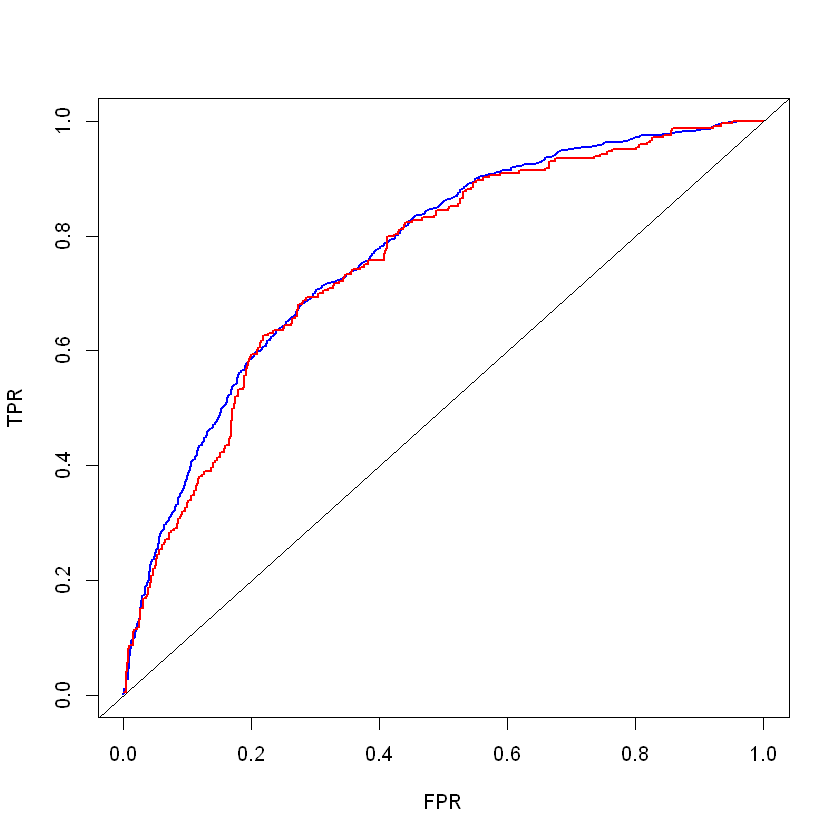

In [39]:
simple_roc <- function(labels, scores){
  labels <- labels[order(scores, decreasing=TRUE)]
  data.frame(TPR=cumsum(labels)/sum(labels), FPR=cumsum(!labels)/sum(!labels), labels)
}
roc.train = simple_roc(train.data$clinical.outcome %in% "Success",
                      train.data$pred.prob)
roc.test = simple_roc(test.data$clinical.outcome %in% "Success",
                      test.data$pred.prob)
plot(TPR ~ 1 - FPR, roc.train, type = "l", lwd = 2, col = "blue")
lines(TPR ~ 1 - FPR, roc.test, lwd = 2, col = "red")
abline(0, 1)

## Some cautionary notes
While the strategy of using the historical drug development record to fit models of target--indication success has many advantages, we also need to be aware of limitations in the data.  For example:
* Less than 5% of protein--coding genes have ever been explored in the clinic
* The proteins that have been explored in the clinic represent a very biased subset of the coding genes as a whole

In [40]:
n_distinct(all.data$entrez_id)
all.data  %>% 
    group_by(clinical.outcome) %>% 
    summarise(unique = n_distinct(entrez_id))

[1] 793

clinical.outcome,unique
Failure,741
Success,325


* A modest number of diseases have been explored, and for a highly biased subset of corresponding targets

In [41]:
n_distinct(all.data$MeSH_ID)
all.data  %>% 
    group_by(clinical.outcome) %>% 
    summarise(unique = n_distinct(MeSH_ID))

[1] 399

clinical.outcome,unique
Failure,310
Success,297


* Some indications have been pursued by a lot of targets

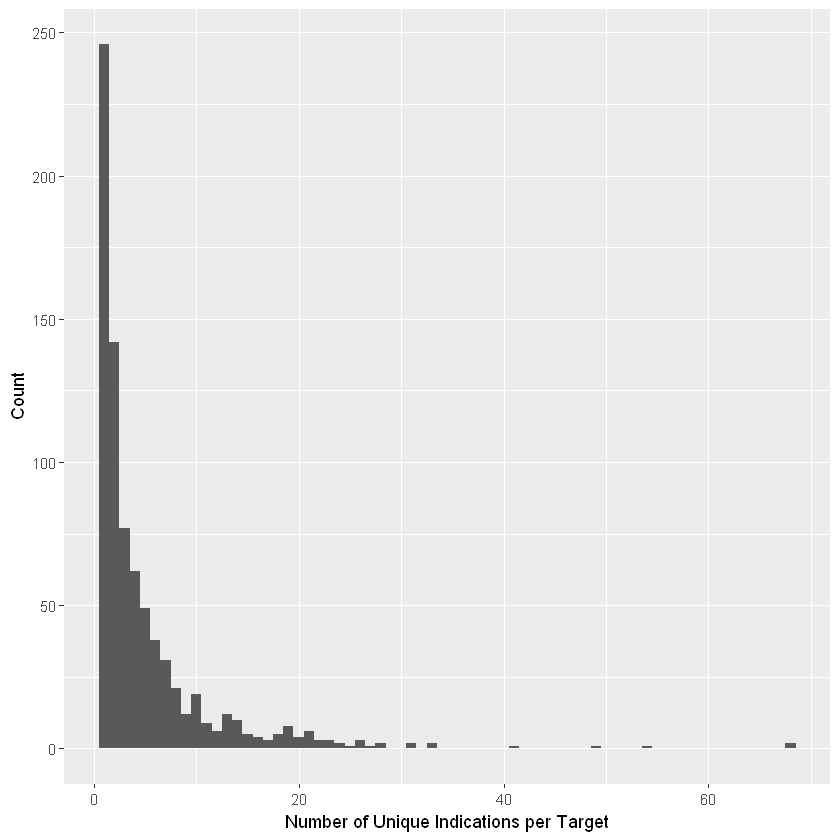

In [42]:
x <- table(as.character(all.data$entrez_id))
g <- ggplot(data.frame(Ind = x), aes(Ind.Freq)) + geom_histogram(binwidth = 1) +
    labs(x = "Number of Unique Indications per Target", y = "Count")
print(g)

* Some targets have been studied for lots of indications

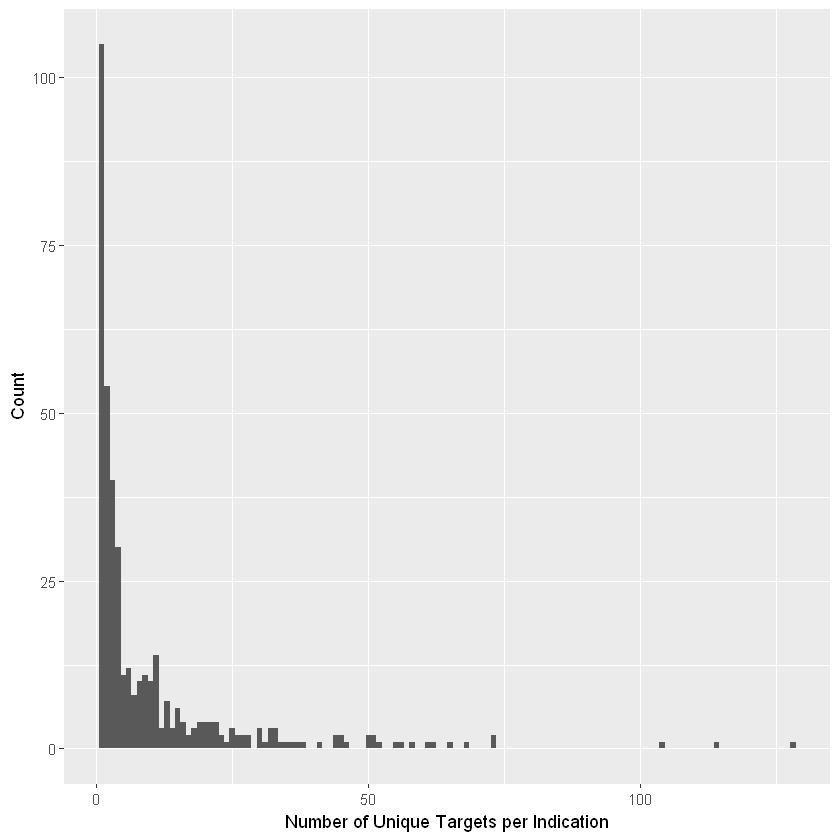

In [43]:
x <- table(as.character(all.data$MeSH_ID))
g <- ggplot(data.frame(Ind = x), aes(Ind.Freq)) + geom_histogram(binwidth = 1) +
    labs(x = "Number of Unique Targets per Indication", y = "Count")
print(g)

* Targets that have been tried for a larger number of indications show a higher proportion of success, with a strong preference for indication adjacencies.  These could be considered as duplicates of one another

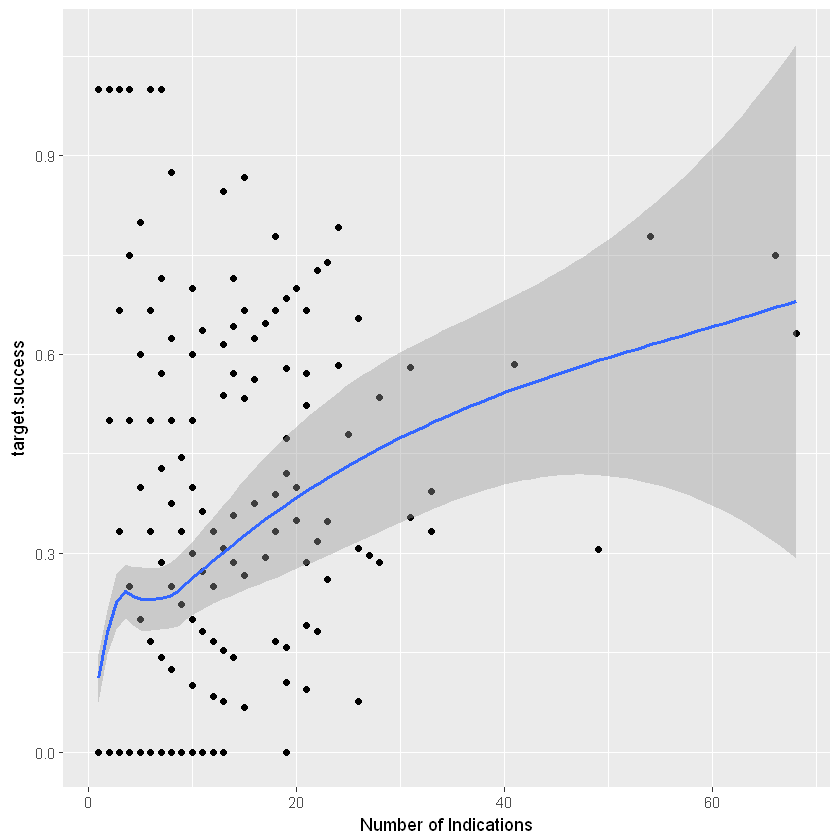

In [44]:
success.fxn = function(x) { sum(x %in% "Success")/length(x) }
target.success = all.data %>% 
    group_by(entrez_id) %>%
    summarise(ind.count = n_distinct(MeSH_ID), 
              target.success = success.fxn(clinical.outcome))
g <- ggplot(target.success, aes(ind.count, target.success)) + geom_point() +
    geom_smooth(method = "loess") + xlab("Number of Indications")
print(g)

## Repeating simple logistic model without duplicate targets

We can assess the robustness of our prediction model by repeating the logistic regression model selection on a subset of the data that retains only a single, randomly selected indication for each target.

In [45]:
## Create subset of all.data, randomly selecting one indication per target
u.all.data = subset(all.data[sample(1:nrow(all.data)),],
                   !duplicated(entrez_id))
## Randomly select training and test set
u.all.data$Train = sample(c(TRUE, FALSE), size = nrow(u.all.data), 
                          replace = TRUE, prob = c(0.8, 0.2))
summary(u.all.data[, c("clinical.outcome", "entrez_id", "MeSH_ID", "Train")])

 clinical.outcome   entrez_id            MeSH_ID      Train        
 Failure:629      Min.   :        2   D001172: 38   Mode :logical  
 Success:164      1st Qu.:     1816   D011565: 34   FALSE:154      
                  Median :     3717   D009190: 30   TRUE :639      
                  Mean   :   137514   D001249: 26                  
                  3rd Qu.:     6356   D003424: 19                  
                  Max.   :100133941   D003924: 19                  
                                      (Other):627                  

In [46]:
u.train.data = subset(u.all.data, Train)
u.test.data = subset(u.all.data, !Train)
u.indep.vars = indep.vars[!(indep.vars %in% "phenodigm.pos")]

u.full.glm = glm(clinical.outcome ~ ., 
                u.train.data[, c("clinical.outcome", u.indep.vars)],
              family = binomial)
u.backward.glm = step(u.full.glm, trace = 0)
anova(u.backward.glm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,638,642.8274,NA
rna_expression.pos,1,36.853938,637,605.9734,1.273186e-09
animal_model.pos,1,20.780965,636,585.1924,5.149223e-06
literature.pos,1,8.882378,635,576.3101,2.879362e-03
uniprot_literature.pos,1,7.197581,634,569.1125,7.300190e-03
expression_score.pos,1,3.273664,633,565.8388,7.040023e-02
GTEX_median_all_tissues.pos,1,3.418020,632,562.4208,6.448830e-02
topology_type,4,10.523575,628,551.8972,3.247380e-02


In [47]:
u.test.data$pred.prob = predict(u.backward.glm, newdata = u.test.data, 
                            type = "response")
u.train.data$pred.prob = predict(u.backward.glm, newdata = u.train.data, 
                              type = "response")

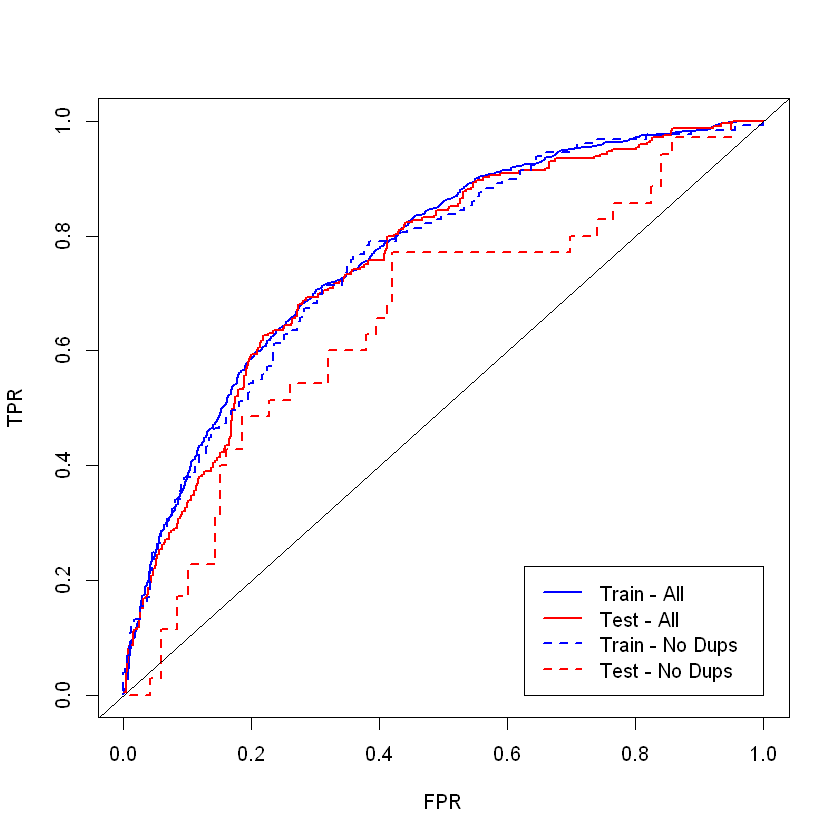

In [48]:
u.roc.train = simple_roc(u.train.data$clinical.outcome %in% "Success",
                      u.train.data$pred.prob)
u.roc.test = simple_roc(u.test.data$clinical.outcome %in% "Success",
                      u.test.data$pred.prob)
plot(TPR ~ 1 - FPR, roc.train, type = "l", lwd = 2, col = "blue")
lines(TPR ~ 1 - FPR, roc.test, lwd = 2, col = "red")
lines(TPR ~ 1 - FPR, u.roc.train, lwd = 2, col = "blue", lty = 2)
lines(TPR ~ 1 - FPR, u.roc.test, lwd = 2, col = "red", lty = 2)
abline(0, 1)
legend(1, 0, c("Train - All", "Test - All", "Train - No Dups", "Test - No Dups"), 
       lty = c(1, 1, 2, 2), lwd = 2, col = rep(c("blue", "red"), 2), xjust = 1, yjust = 0)